# Spam message recognition using three NN models

Load necessary libraries 

In [24]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
from keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

### Load and explore the dataset

Let us load the data set from the git url. Note that the .txt file of the dataset is also available in this git repo, if the url would expire or not work for some reason. 

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv', encoding='ISO-8859-1')
# rename the columns
df = df[['v1','v2']]
df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [27]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

We see that the dataset includes 5572 messages, 747 of which are spam. There are also duplicate entries for both ham and spam.

#### Word Cloud visualization

A nice way to visually look at text data is to make a word cloud, which showcases the most common words within a string of text. We can do so by applying two helpful function: 1. convert the message data column to a str for a single message label (ham or spam) and 2. plot the words from the resulting string.

In [28]:
def data_to_str(df, lable):
    '''Convert data column to string for ham or spam'''
    ham =  df[df['label']== lable]
    ham_msg_cloud = str(ham['message'])
    return ham_msg_cloud

In [29]:
def Word_cloud(lable_str):
    '''Show word cloud using the result of function data_to_str'''
    msg_cloud = WordCloud(width =520, 
                          height =260, stopwords = STOPWORDS, 
                          max_font_size = 50, background_color = "black", 
                          colormap = 'Pastel1').generate(lable_str)
    plt.figure(figsize=(16,10))
    plt.imshow(msg_cloud, interpolation = 'bilinear')
    plt.axis('off') # turn off axis
    plt.show()

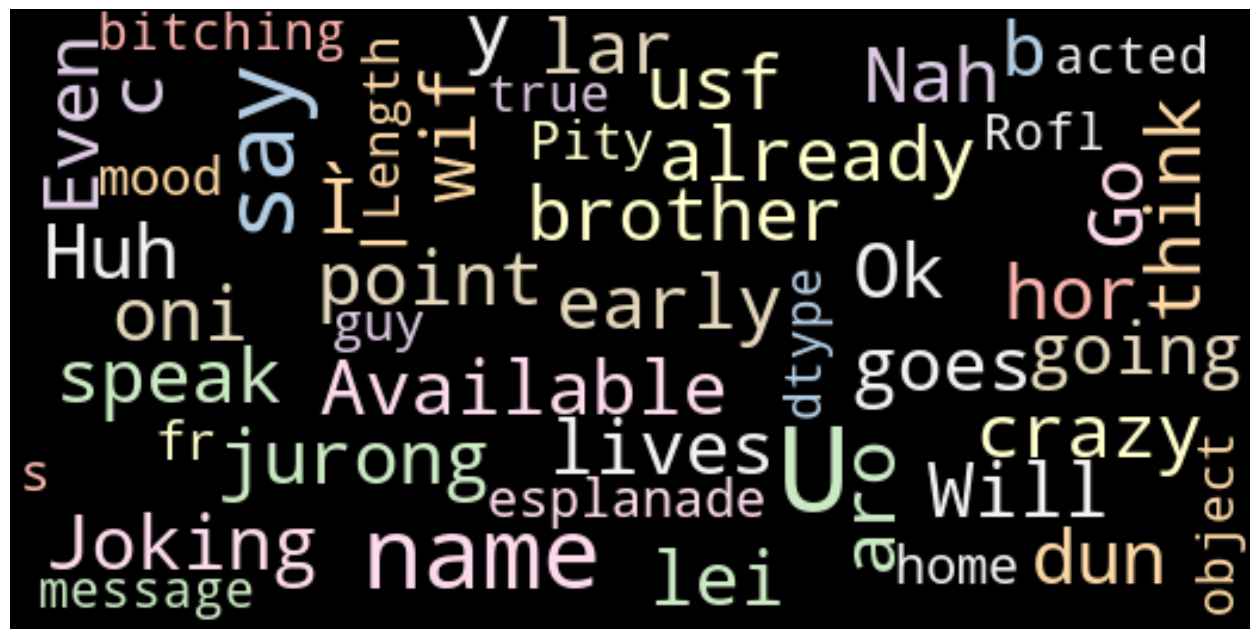

In [30]:
ham_msg_text = data_to_str(df, 'ham')
Word_cloud(ham_msg_text)

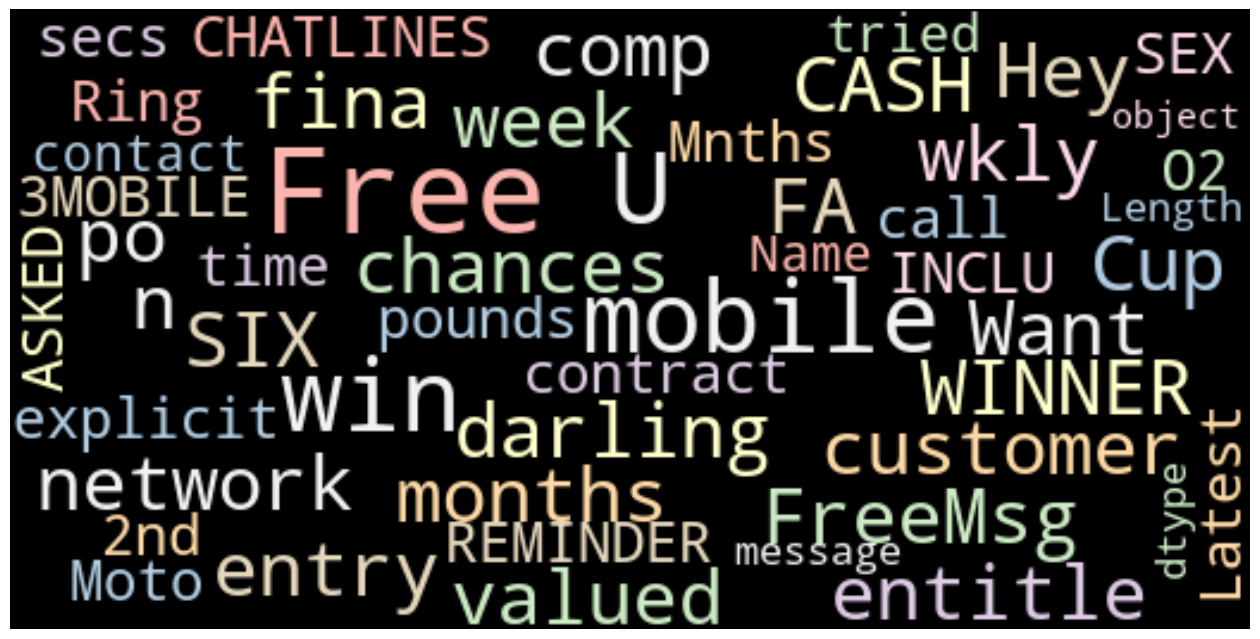

In [31]:
spam_msg_text = data_to_str(df, 'spam')
Word_cloud(spam_msg_text)

If we were to ask somebody which cloud represents spam messages he would probably guess correctly. For we can see that "Free", "Winner", "Win", "Cash", "Sex" are among the common spam related words.

In [32]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


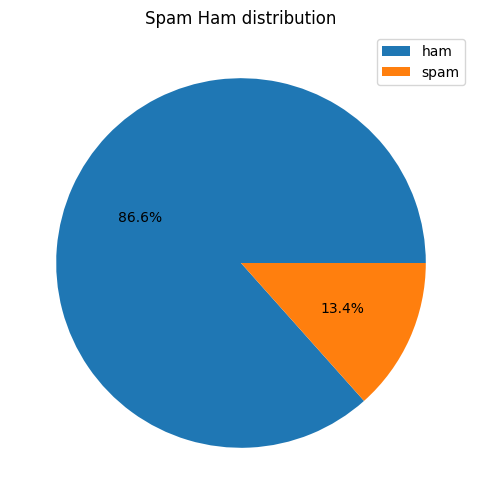

In [33]:
plt.figure(figsize=(10,6))
plt.pie(df['label'].value_counts(),autopct='%1.1f%%')
plt.title("Spam Ham distribution")
labels = ['ham', 'spam']
plt.legend(labels, loc="best")


We not that the data is imbalanced in terms of the target, which is commonly the case for most classification problems.

### Modeling 

Let us now map the labels using 0 and 1, where 1 is spam, so we may used the label column as our target 

In [34]:
df['label'] = df['label'].map({'ham':0, 'spam':1})

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=434)

Let us now convert the text message data into numerical representation, so the model will understand it, this is called tokenization.

In [36]:
# Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [37]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

The Tokenizer API from TensorFlow Keras can split sentences into words and encode them into integers. The Tokenizer will perform all the necessary pre-processing steps:

1. tokenize into word character (word level)
2. num_words for maximum number of unique tokens
3. filter out the punctuation terms
4. convert all words to lower case
5. convert all words to integer index

In [38]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

8004

The next step : Let’s represent each sentence by sequences of numbers using texts_to_sequencesfrom Tokenizer object. After that, we padded the sequence so that we can have same length of each sequence. We do this for both the test and train data.

In [39]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [40]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [41]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (4457, 50)
Shape of testing tensor:  (1115, 50)


### Dense model

Define the dense classifier model architecture:

In the first version of this script I did not take any thought in the initialization options that Keras offers and left it to work as its default. Initialization is the starting point of the weights in the network. The [article](https://towardsdatascience.com/random-initialization-for-neural-networks-a-thing-of-the-past-bfcdd806bf9e) by Aditya Ananthram
on Medium gives a nice and easy to understand overview of this problem. 

The different initialization options can be found in the [Keras documentation](https://keras.io/api/layers/initializers/). I will be using the HeNormal() initializer for all for NN models, the gain isn't spectacular (accuracy is still high in the first epoch without specifying and initialization, which by default is global uniform) but generally setting up a good initializer reduces the number of epochs needed for optimal accuracy.  
  

In [42]:
initializer = tf.keras.initializers.HeNormal()

In [43]:
# Define parameter
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu', kernel_initializer = initializer))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid', kernel_initializer = initializer))

C:\Users\ddash\AppData\Roaming\Python\Python39\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Sequential calls for Keras sequential model in which layer added in a sequence. The embedding layer maps each word to a N-dimensional vector of real numbers. The embedding_dim is the size of the word_vector, in this case we use 16. Because the embedding layer is the first hidden layer in our model, we need to set our input layer as defined by the input_length = max_len

Next, we use the GlobalAveragePooling1D as the pooling layer, which helps to reduce the number of parameters in the model and to avoid overfitting.

Next, we use a dense layer with activation function relu followed by a dropout layer to avoid overfitting and a final output layer with sigmoid activation function. The sigmoid activation function outputs probabilities will between 0 and 1.

The summary of the dense model:

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

Next we compile the model. We use the binary_crossentropy as a loss function because the output of the model is binary and for the optimizer, we use adam which makes use of momentum to avoid local minima.

In [45]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

Now we are ready to train the model.
- epoch : number of times the learning algorithm will work through the entire training data.
- callbacks : to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after 2 epochs, then the model training will stop. This technique helps to avoid overfitting problem.
- verbose : 2 , it will show us loss and accuracy on each epoch.

In [46]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30


140/140 - 2s - loss: 0.4526 - accuracy: 0.8631 - val_loss: 0.3028 - val_accuracy: 0.8771 - 2s/epoch - 11ms/step
Epoch 2/30
140/140 - 0s - loss: 0.2698 - accuracy: 0.8726 - val_loss: 0.1940 - val_accuracy: 0.9157 - 299ms/epoch - 2ms/step
Epoch 3/30
140/140 - 0s - loss: 0.1617 - accuracy: 0.9475 - val_loss: 0.1310 - val_accuracy: 0.9605 - 300ms/epoch - 2ms/step
Epoch 4/30
140/140 - 0s - loss: 0.1094 - accuracy: 0.9675 - val_loss: 0.1002 - val_accuracy: 0.9686 - 282ms/epoch - 2ms/step
Epoch 5/30
140/140 - 0s - loss: 0.0797 - accuracy: 0.9769 - val_loss: 0.0866 - val_accuracy: 0.9713 - 288ms/epoch - 2ms/step
Epoch 6/30
140/140 - 0s - loss: 0.0632 - accuracy: 0.9798 - val_loss: 0.0805 - val_accuracy: 0.9722 - 298ms/epoch - 2ms/step
Epoch 7/30
140/140 - 0s - loss: 0.0555 - accuracy: 0.9823 - val_loss: 0.0779 - val_accuracy: 0.9731 - 301ms/epoch - 2ms/step
Epoch 8/30
140/140 - 0s - loss: 0.0500 - accuracy: 0.9841 - val_loss: 0.0746 - val_accuracy: 0.9785 - 298ms/epoch - 2ms/step
Epoch 9/30
14

Although we set the epochs to 30, the model stopped at 14, which is more then enough since tha accuracy is very high = 0.9794. For a validation data set we used the test dataset, so we need not validate further. If the dataset was a bit larger we could have made 3 splits and have a validation dataset as well.

We may now plot the accuracy and loss comparing train and validation curves by epochs.

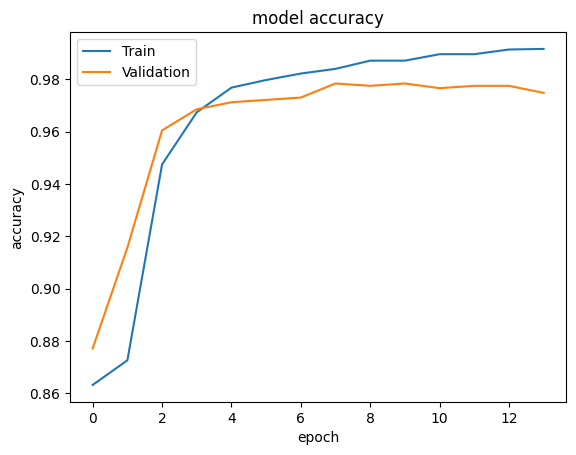

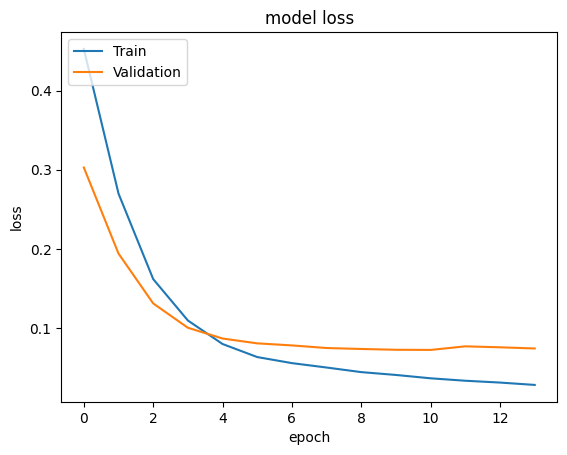

In [47]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In a sense even 6 epochs would have been enough since we see that the curves for the both accuracy and loss flattens after the 6th epoch. 

Our results of the train and test dataset look like this.

In [48]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

18/18 - 1s - loss: 0.0243 - accuracy: 0.9934 - 721ms/epoch - 40ms/step
5/5 - 0s - loss: 0.0740 - accuracy: 0.9753 - 50ms/epoch - 10ms/step
Train accuracy: 99.34
Valid accuracy: 97.53


### Long Short Term Memory (LSTM)

Long Short Term Memory (LSTM) was designed to overcome the problems of simple Recurrent Neural Network (RNN) by allowing the network to store data in a sort of memory that it can access at a later times.

In LSTM there are Forget Gate, Input Gate and Output Gate.

- The first step is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “Forget Gate” layer.
- The second step is to decide what new information that we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “Input Gate” layer decides which values we’ll update. Next, a tanh layer which creates a vector of new candidate values that could be added to the state.
- Finally, we need to decide what we are going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between -1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided

LSTM model architecture and summary:

In [49]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid', kernel_initializer = initializer))

In [50]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 16)            0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82369 (321.75 KB)
Trainable params: 82369 (321.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________

Compile and train

In [51]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [52]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
140/140 - 12s - loss: 0.2292 - accuracy: 0.9224 - val_loss: 0.1332 - val_accuracy: 0.9632 - 12s/epoch - 85ms/step
Epoch 2/30
140/140 - 8s - loss: 0.0887 - accuracy: 0.9758 - val_loss: 0.1383 - val_accuracy: 0.9659 - 8s/epoch - 60ms/step
Epoch 3/30
140/140 - 7s - loss: 0.0816 - accuracy: 0.9717 - val_loss: 0.0979 - val_accuracy: 0.9758 - 7s/epoch - 48ms/step
Epoch 4/30
140/140 - 7s - loss: 0.0582 - accuracy: 0.9796 - val_loss: 0.1167 - val_accuracy: 0.9722 - 7s/epoch - 47ms/step
Epoch 5/30
140/140 - 6s - loss: 0.0466 - accuracy: 0.9888 - val_loss: 0.0805 - val_accuracy: 0.9767 - 6s/epoch - 46ms/step
Epoch 6/30
140/140 - 6s - loss: 0.0434 - accuracy: 0.9897 - val_loss: 0.1042 - val_accuracy: 0.9776 - 6s/epoch - 45ms/step
Epoch 7/30
140/140 - 6s - loss: 0.0588 - accuracy: 0.9856 - val_loss: 0.0961 - val_accuracy: 0.9749 - 6s/epoch - 45ms/step


The model has a similar loss and accuracy compared to the Dense model, but it achieved this results only with 6 epochs.     

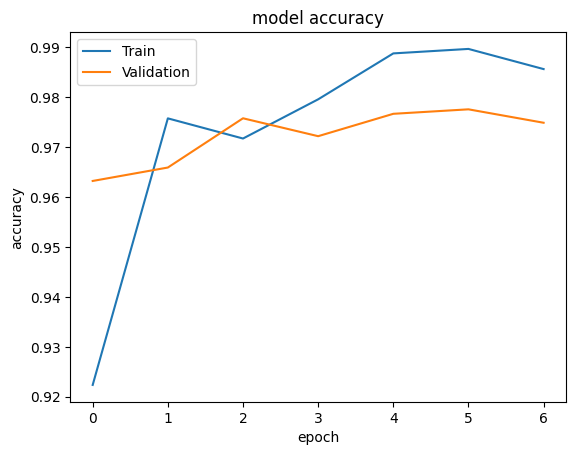

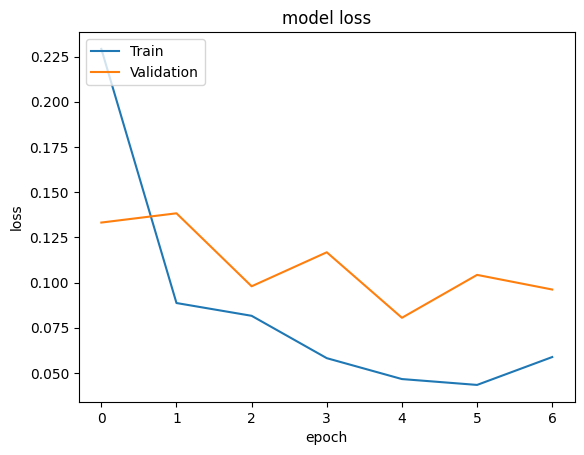

In [53]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

18/18 - 2s - loss: 0.0363 - accuracy: 0.9916 - 2s/epoch - 115ms/step
5/5 - 0s - loss: 0.0961 - accuracy: 0.9739 - 301ms/epoch - 60ms/step
Train accuracy: 99.16
Valid accuracy: 97.39


### Bidirectional Long Short Term Memory (Bi-LSTM)

A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence). Unlike standard LSTM, the input flows of Bi-LSTM in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation.

In [56]:
# Define parameter
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid', kernel_initializer = initializer))


In [57]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               148480    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 156737 (612.25 KB)
Trainable params: 156737 (612.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [59]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30


140/140 - 14s - loss: 0.2111 - accuracy: 0.9233 - val_loss: 0.1166 - val_accuracy: 0.9587 - 14s/epoch - 101ms/step
Epoch 2/30
140/140 - 9s - loss: 0.0732 - accuracy: 0.9789 - val_loss: 0.0820 - val_accuracy: 0.9731 - 9s/epoch - 64ms/step
Epoch 3/30
140/140 - 9s - loss: 0.0959 - accuracy: 0.9711 - val_loss: 0.1244 - val_accuracy: 0.9704 - 9s/epoch - 64ms/step
Epoch 4/30
140/140 - 9s - loss: 0.0549 - accuracy: 0.9856 - val_loss: 0.0807 - val_accuracy: 0.9794 - 9s/epoch - 66ms/step
Epoch 5/30
140/140 - 8s - loss: 0.0407 - accuracy: 0.9888 - val_loss: 0.0986 - val_accuracy: 0.9785 - 8s/epoch - 60ms/step
Epoch 6/30
140/140 - 8s - loss: 0.0315 - accuracy: 0.9917 - val_loss: 0.1058 - val_accuracy: 0.9776 - 8s/epoch - 58ms/step


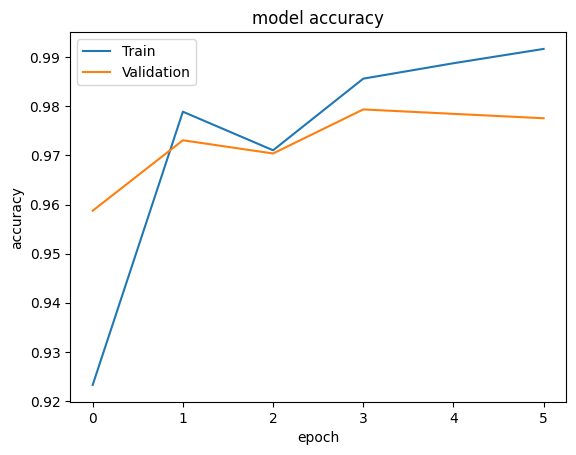

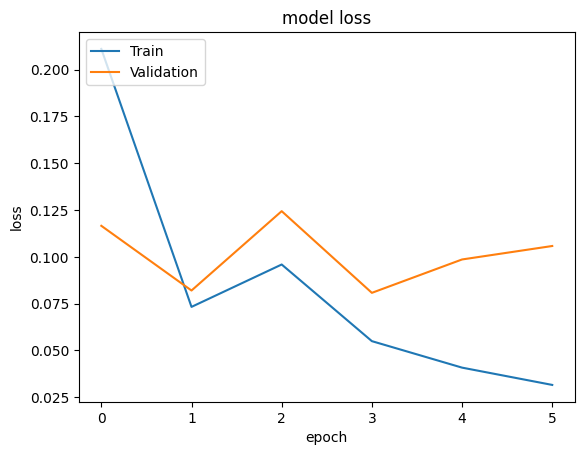

In [60]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We note here that at the 3th epoch the loss started to increase and the accuracy, which is bad. Three epochs would have performed better.

In [61]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

18/18 - 3s - loss: 0.0297 - accuracy: 0.9923 - 3s/epoch - 164ms/step
5/5 - 0s - loss: 0.1058 - accuracy: 0.9762 - 437ms/epoch - 87ms/step
Train accuracy: 99.23
Valid accuracy: 97.62


### Gated Recurrent Unit (GRU)

A Gated Recurrent Unit, or GRU, is a type of recurrent neural network. It is similar to an LSTM, but only has two gates — a reset gate and an update gate and notably lacks an output gate. Fewer parameters means GRUs are generally easier/faster to train than their LSTM counterparts.

Lets run the GRU by the same steps as the last 3 models.

In [62]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))

In [63]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_1 (Spati  (None, 50, 16)            0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 128)               56064     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 64193 (250.75 KB)
Trainable params: 64193 (250.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [64]:
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])

In [65]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30


140/140 - 9s - loss: 0.4309 - accuracy: 0.8589 - val_loss: 0.3722 - val_accuracy: 0.8771 - 9s/epoch - 63ms/step
Epoch 2/30
140/140 - 5s - loss: 0.3810 - accuracy: 0.8670 - val_loss: 0.1447 - val_accuracy: 0.9623 - 5s/epoch - 39ms/step
Epoch 3/30
140/140 - 5s - loss: 0.1245 - accuracy: 0.9571 - val_loss: 0.0952 - val_accuracy: 0.9758 - 5s/epoch - 39ms/step
Epoch 4/30
140/140 - 5s - loss: 0.0550 - accuracy: 0.9841 - val_loss: 0.0901 - val_accuracy: 0.9767 - 5s/epoch - 37ms/step
Epoch 5/30
140/140 - 5s - loss: 0.0424 - accuracy: 0.9877 - val_loss: 0.0703 - val_accuracy: 0.9794 - 5s/epoch - 37ms/step
Epoch 6/30
140/140 - 5s - loss: 0.0440 - accuracy: 0.9892 - val_loss: 0.0697 - val_accuracy: 0.9794 - 5s/epoch - 36ms/step
Epoch 7/30
140/140 - 5s - loss: 0.0368 - accuracy: 0.9886 - val_loss: 0.0838 - val_accuracy: 0.9785 - 5s/epoch - 37ms/step
Epoch 8/30
140/140 - 5s - loss: 0.0310 - accuracy: 0.9910 - val_loss: 0.0664 - val_accuracy: 0.9812 - 5s/epoch - 36ms/step
Epoch 9/30
140/140 - 5s - l

The model completed for 10 epochs

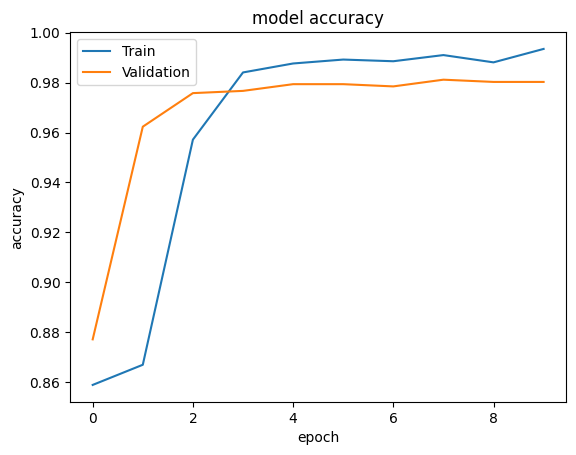

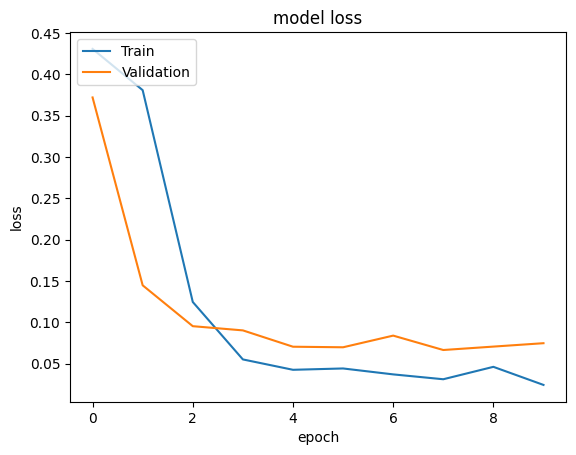

In [67]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Now let us compare all four models in terms of accuracy and loss.

In [68]:
# Comparing the four different models
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test)} " )
print(f"GRU model loss and accuracy: {model3.evaluate(testing_padded, y_test)}")

 1/35 [..............................] - ETA: 1s - loss: 0.0180 - accuracy: 1.0000

35/35 [==============================] - 0s 2ms/step - loss: 0.0740 - accuracy: 0.9749
Dense model loss and accuracy: [0.07403617352247238, 0.9748879075050354] 
35/35 [==============================] - 1s 19ms/step - loss: 0.0961 - accuracy: 0.9749
LSTM model loss and accuracy: [0.09614767879247665, 0.9748879075050354] 
35/35 [==============================] - 1s 22ms/step - loss: 0.1058 - accuracy: 0.9776
Bi-LSTM model loss and accuracy: [0.10576677322387695, 0.9775784611701965] 
35/35 [==============================] - 0s 13ms/step - loss: 0.0746 - accuracy: 0.9803
GRU model loss and accuracy: [0.07460862398147583, 0.9802690744400024]


Technically speaking all models come so close any of them would work fine. The Dense classifier took more epochs then the rest, so it is more computationally demanding. The best approach to validate our models with a new spam  and ham message.   

In [69]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me"]

In [70]:
def predict_spam(predict_msg, model):
  '''Predic spam with a custom made message'''
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))

In [71]:
predict_spam(predict_msg, model)

1/1 [==============================] - 0s 181ms/step


array([[0.34695664],
       [0.0130044 ]], dtype=float32)

In [72]:
predict_spam(predict_msg, model1)

1/1 [==============================] - 1s 801ms/step


array([[0.11964975],
       [0.00253724]], dtype=float32)

In [73]:
predict_spam(predict_msg, model2)

1/1 [==============================] - 1s 929ms/step


array([[0.03220338],
       [0.00208117]], dtype=float32)

In [74]:
predict_spam(predict_msg, model3)

1/1 [==============================] - 0s 486ms/step


array([[0.25391132],
       [0.00091165]], dtype=float32)

The first model (Dense) works best in guessing the spam. Let us try with something more dramatic

In [75]:
predict_msg2 = ["You won 100000000$ in the USA lottery! Please send us IBAN so you may receive your prize",
               "Can you send me the ten dollars you promised, use Revolut"]

In [76]:
predict_spam(predict_msg2, model)

1/1 [==============================] - 0s 27ms/step


array([[0.7242304 ],
       [0.02472233]], dtype=float32)

In [77]:
predict_spam(predict_msg2, model1)

1/1 [==============================] - 0s 42ms/step


array([[0.96088773],
       [0.00269203]], dtype=float32)

In [78]:
predict_spam(predict_msg2, model2)

1/1 [==============================] - 0s 42ms/step


array([[0.99869967],
       [0.00432084]], dtype=float32)

In [79]:
predict_spam(predict_msg2, model3)

1/1 [==============================] - 0s 35ms/step


array([[9.485806e-01],
       [8.149345e-04]], dtype=float32)

Interestingly when we maid the spam "more obvious" the Dense model came in last. We could go one like this forever, you can try it for yourself, but our best option would be to test the models on new data, outside the SMSSpamCollection.

### Conclusion

There are several ways the code here could have been improved. More feature engineering for one thing, since we used only the text message, but we might have considered also the length of the message, frequency of UPPER verse lowers caps, presence of special symbols like $ or other currencies. We could have applied some balancing technique to the dataset, since only 13.4% of the messages are spam. For validation we might consider using a fresh data unknown to are models to make the final say which NN works best.  